<div class="alert alert-block alert-success">
<b>NOTEBOOK 3 - EDA
</div>

---
# 1 - IMPORTS

### 1.1 - SETUP PROJECT

In [4]:
# IMPORTS

# Standard libraries
import sys
import importlib
from pathlib import Path
import json  # for saving split metadata

# Third-party
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency, f_oneway


sns.set(style="whitegrid")  # clean background for all plots

# Add "../src/utilities" to sys.path for custom utilities
sys.path.append("../src/utilities")  # Ensure src/ is in path

# Import utils (reload to pick up latest edits)
try:
    import utils
    importlib.reload(utils)   # Ensures latest version is loaded
except ImportError as e:
    raise ImportError(f"Could not import utils module: {e}")

---
# 2 - DATASET LOAD

### 2.1 - LOADING

I have loaded the train and test back in. More specifically, I will perform the EDA on the train set.

**Why is that?**
Because by doing so, the findings won't be affected by the test data points (which act as unseen data). 

In [5]:
# Load as pickle files 
X_train = pd.read_pickle("../data/interim/03_X_train_aftersplit.pkl")
X_test = pd.read_pickle("../data/interim/03_X_test_aftersplit.pkl")
y_train = pd.read_pickle("../data/interim/03_y_train_aftersplit.pkl")
y_test = pd.read_pickle("../data/interim/03_y_test_aftersplit.pkl")

### 2.2 - QUICK CHECK

In [6]:
# A quick peek at the data shape

print('X_train shape:', X_train.shape)
print('y_train shape:', X_train.shape)

# Get basic info about each column
X_train.info()

# Basic statistics for numerical columns
X_train.describe()

# Look for duplicate rows
duplicates = X_train.duplicated().sum()

print(f"\nDuplicate rows: {duplicates}")

# Glue X and y for EDA convenience
y = y_train.squeeze()                      # ensure 1D
y = y.astype("string")                     # consistent class labels
eda = X_train.copy()
eda["__target__"] = y                      # add target for EDA

# Numeric = number dtype
categorical_cols = eda.select_dtypes(include=["category"]).columns.tolist()

# Categorical = non-numeric excluding the target
numeric_cols= []
for col in eda.columns:
    if col not in categorical_cols and col != "__target__":
        numeric_cols.append(col)

print("Schema snapshot")
print(f"- Numeric cols: {len(numeric_cols)}")
print(f"- Categorical cols: {len(categorical_cols)}")
print(f"- Target classes: {sorted(eda['__target__'].dropna().unique().tolist())}")

X_train shape: (3477, 30)
y_train shape: (3477, 30)
<class 'pandas.core.frame.DataFrame'>
Index: 3477 entries, 3215 to 253
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   marital                    3477 non-null   category
 1   app_mode                   3477 non-null   category
 2   app_order                  3477 non-null   int64   
 3   course                     3477 non-null   category
 4   att_mode                   3477 non-null   category
 5   prev_qual                  3477 non-null   category
 6   prev_grade                 3477 non-null   float64 
 7   nationality                3477 non-null   category
 8   mother_qual                3477 non-null   category
 9   father_qual                3477 non-null   category
 10  mothers_occupation         3477 non-null   category
 11  fathers_occupation         3477 non-null   category
 12  admission_grade            3477 non-null 

**Dataset Summary**  
The training set consists of **3477 records** and **30 features**, with the target variable stored separately. The schema is evenly balanced between *15 categorical* and *15 numeric* features (9 integers and 6 floats). Examples of categorical variables include *marital status, application mode, course, attendance mode, nationality, gender,* and *scholarship holder*, while numeric variables cover measures such as *application order, previous qualification grade, admission grade, age at enrollment, semester grades, unemployment rate, inflation,* and *GDP*.  

All columns are fully populated with **no missing values** and **no duplicate rows**, ensuring a clean base for analysis. The target variable is multi-class with three categories: *Dropout, Enrolled,* and *Graduate*. This balanced structure provides a strong foundation for exploratory data analysis, allowing for both statistical summaries and visual exploration across categorical and numeric dimensions.  

In summary:
Here are the main characteristics of the train set:
>- **Dataset size**: 3477 data points - enough for modeling
>- **Feature types**: match the ones defined before
>- **Missing values**: non-existent
>- **Data ranges**: addressed before (I will check for potential outliers later on)

---
# 3 - EDA

Below I have performed an in-depth EDA to understand the main characteristics of the training set.
I started off plotting the missing values chart, then I moved on to analyzing the target variable and eventually diveinto the features. I will also check for potential outliers and correlations/multicollinearity between features.

### 3.1 - MISSINGNESS OVERVIEW


Missingness (%) — top 15
marital                      0.0
app_mode                     0.0
app_order                    0.0
course                       0.0
att_mode                     0.0
prev_qual                    0.0
prev_grade                   0.0
nationality                  0.0
mother_qual                  0.0
father_qual                  0.0
mothers_occupation           0.0
fathers_occupation           0.0
admission_grade              0.0
displaced                    0.0
educational_special_needs    0.0


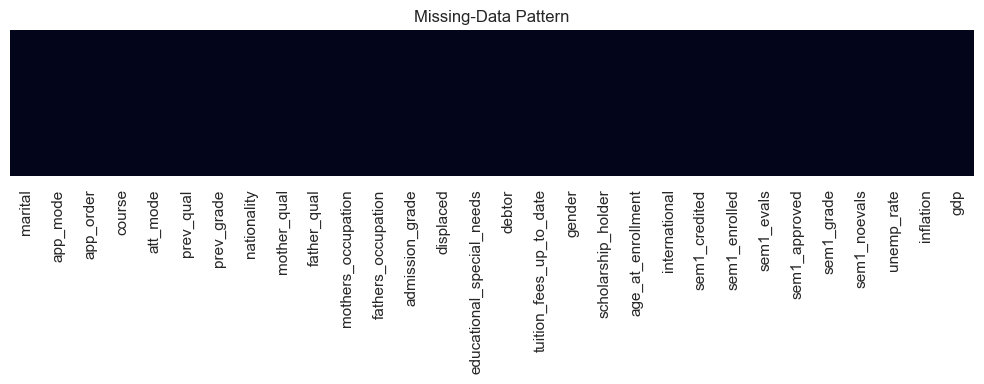

In [7]:
# Missing values plot
print("\nMissingness (%) — top 15")
miss_pct = eda.drop(columns="__target__").isnull().mean().mul(100).sort_values(ascending=False)
print(miss_pct.head(15).round(2).to_string())

plt.figure(figsize=(10, 4))
sns.heatmap(eda.drop(columns="__target__").isnull(),
            cbar=False, yticklabels=False)
plt.title("Missing-Data Pattern")
plt.tight_layout()
plt.show()

As already found out, there are no missing values.

### 3.2 - TARGET ANALYSIS (CATEGORICAL)

I started off the EDA by taking a closer look at the target.

Target distribution
Counts:
__target__
Graduate    1767
Dropout     1075
Enrolled     635

Proportions (%):
__target__
Graduate    50.82
Dropout     30.92
Enrolled    18.26


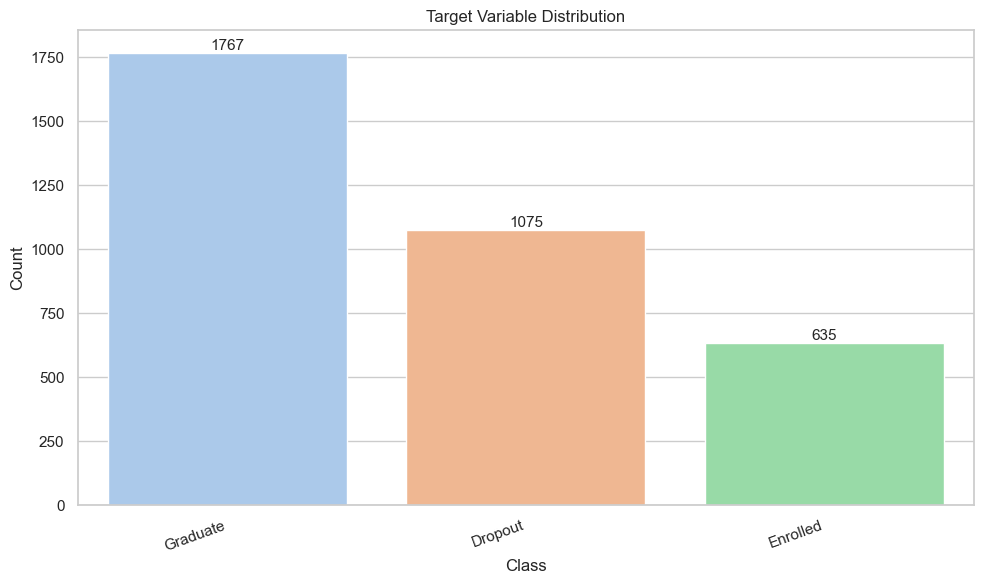

In [8]:
# Basic target distribution
print("Target distribution")
t_counts = eda["__target__"].value_counts(dropna=False)
t_props  = eda["__target__"].value_counts(dropna=False, normalize=True).mul(100).round(2)
print("Counts:\n" + t_counts.to_string())
print("\nProportions (%):\n" + t_props.to_string())

t_df = (t_counts.rename_axis("class").reset_index(name="count")
                 .sort_values("count", ascending=False))

# Bar plot of target distribution
plt.figure(figsize=(10, 6))
sns.barplot(data=t_df, x="class", y="count", hue="class", palette="pastel", legend=False)
plt.title("Target Variable Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=20, ha="right")

# value labels
for i, v in enumerate(t_df["count"].to_list()):
    plt.text(i, v, str(v), ha="center", va="bottom", fontsize=11)
plt.tight_layout()
plt.show()

**Target Variable Distribution**  

The dataset shows a three-class target variable with the following distribution:  

| Class     | Count | Proportion (%) |
|-----------|-------|----------------|
| Graduate  | 1767  | 50.82          |
| Dropout   | 1075  | 30.92          |
| Enrolled  | 635   | 18.26          |

The majority of students fall into the *Graduate* category, followed by *Dropout* and a smaller proportion of *Enrolled*. This imbalance will be an important consideration for modeling and evaluation.


### 3.1 - FEATURES (NUMERIC & CATEGORICAL)

Here's a more in-depth analysis of the numeric and categorical features. 


Numeric summary (mean, median, std, min, max, Shapiro-Wilk)
                      mean   median     std    min      max  shapiro_W  shapiro_p
app_order            1.733    1.000   1.311   0.00    9.000      0.624        0.0
prev_grade         132.654  133.100  13.110  95.00  190.000      0.980        0.0
admission_grade    126.931  126.100  14.445  95.00  190.000      0.982        0.0
age_at_enrollment   23.234   20.000   7.534  17.00   70.000      0.710        0.0
sem1_credited        0.718    0.000   2.385   0.00   20.000      0.344        0.0
sem1_enrolled        6.379    6.000   2.350   0.00   26.000      0.696        0.0
sem1_evals           8.434    8.000   4.060   0.00   45.000      0.898        0.0
sem1_approved        4.793    5.000   3.047   0.00   26.000      0.885        0.0
sem1_grade          10.868   12.333   4.661   0.00   18.875      0.677        0.0
sem1_noevals         0.140    0.000   0.682   0.00   12.000      0.211        0.0
unemp_rate          11.575   11.100  

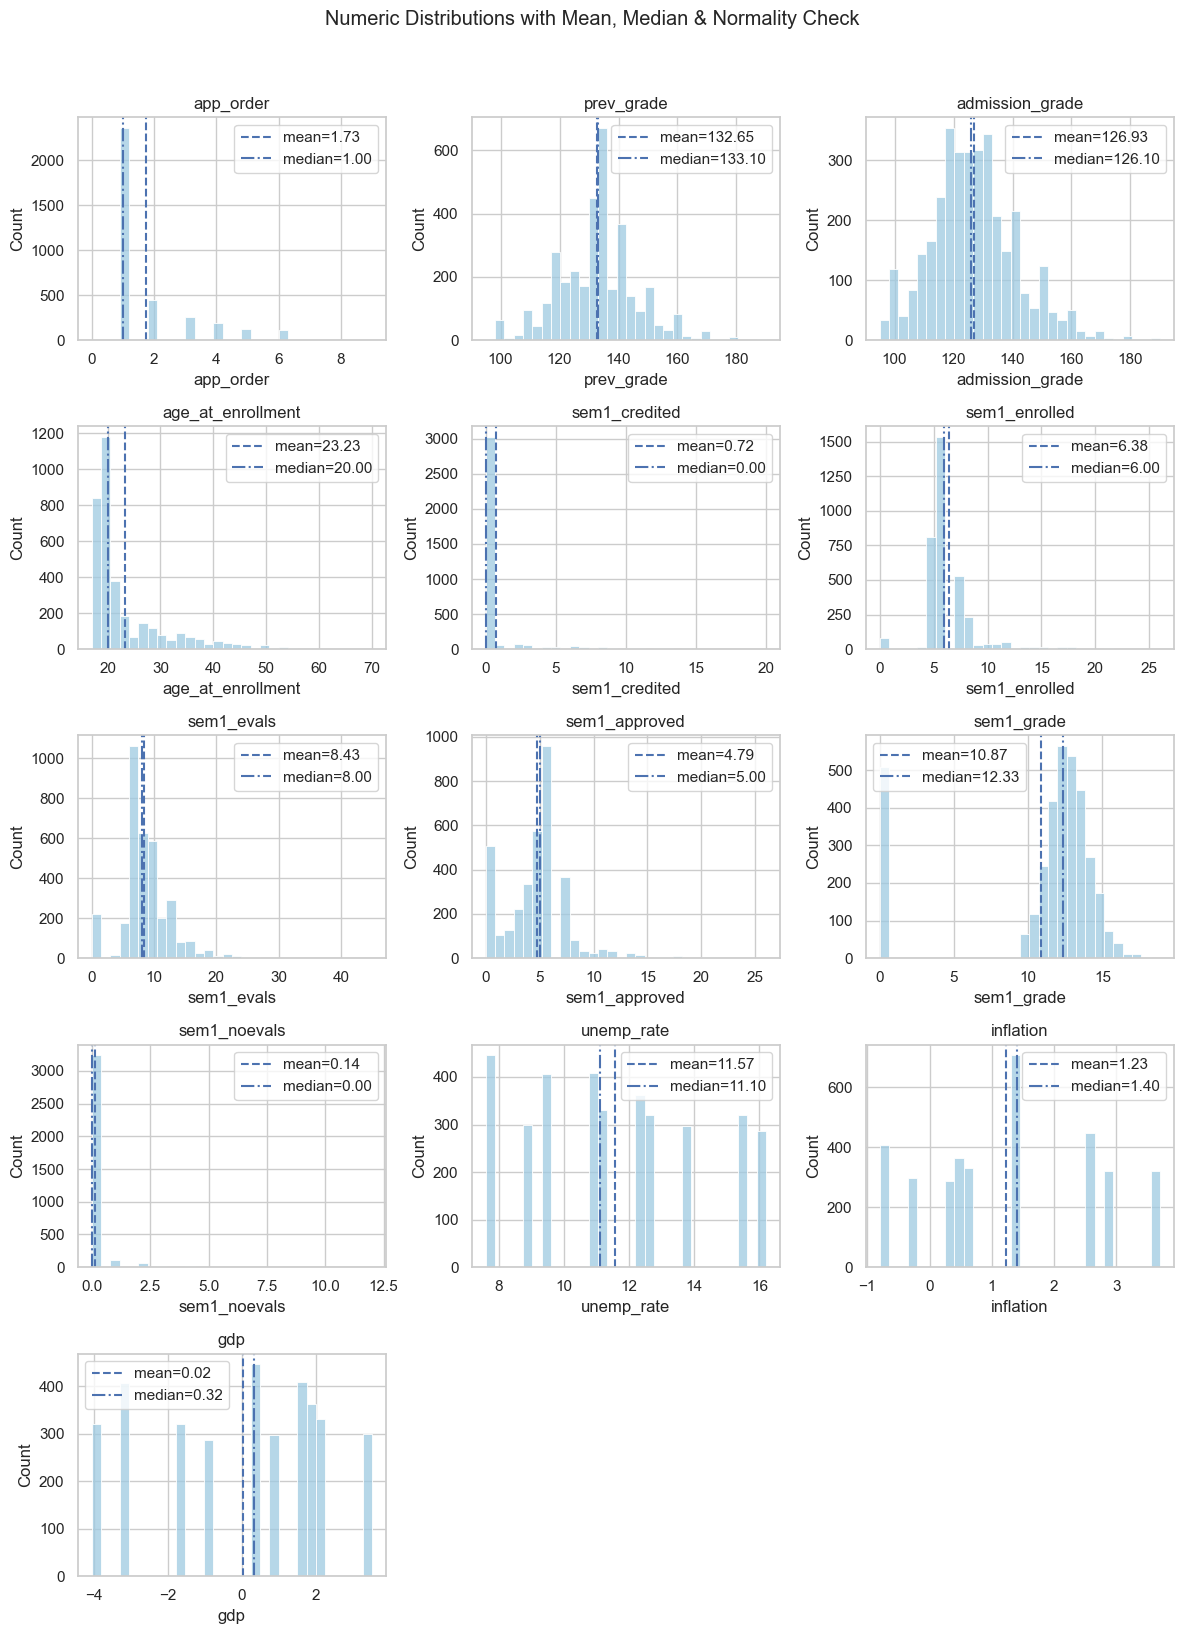

In [23]:
from scipy.stats import shapiro

# NUMERIC COLUMNS DISTRIBUTIONS + NORMALITY
if numeric_cols:
    desc = eda[numeric_cols].describe().T
    desc["median"] = eda[numeric_cols].median()

    # Shapiro test for each numeric col
    shapiro_results = {}
    for col in numeric_cols:
        data = eda[col].dropna()
        # Shapiro requires at least 3 values
        if len(data) >= 3:
            stat, p = shapiro(data.sample(min(len(data), 5000), random_state=42))  
            shapiro_results[col] = {"W": stat, "p": p}
        else:
            shapiro_results[col] = {"W": np.nan, "p": np.nan}

    # Add to summary
    desc["shapiro_W"] = [shapiro_results[c]["W"] for c in desc.index]
    desc["shapiro_p"] = [shapiro_results[c]["p"] for c in desc.index]

    print("\nNumeric summary (mean, median, std, min, max, Shapiro-Wilk)")
    print(desc[["mean","median","std","min","max","shapiro_W","shapiro_p"]]
          .round(3).to_string())

    # Histograms with mean and median overlays
    n_cols = 3
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))
    plt.figure(figsize=(n_cols * 4, n_rows * 3.2))
    for i, col in enumerate(numeric_cols, 1):
        ax = plt.subplot(n_rows, n_cols, i)
        sns.histplot(eda[col], kde=False, bins=30, color="#9ecae1")  # light blue
        m = eda[col].mean()
        med = eda[col].median()
        ax.axvline(m, linestyle="--", linewidth=1.5, label=f"mean={m:.2f}")
        ax.axvline(med, linestyle="-.", linewidth=1.5, label=f"median={med:.2f}")
        ax.set_title(col)
        ax.legend()
    plt.suptitle("Numeric Distributions with Mean, Median & Normality Check", y=1.02)
    plt.tight_layout()
    plt.show()


**Numeric Features Summary**  

The table below shows descriptive statistics (mean, median, std, min, max) together with the **Shapiro–Wilk test** for normality.  

| Feature            | Mean    | Median  | Std    | Min   | Max    | Shapiro-W | p-value |
|--------------------|---------|---------|--------|-------|--------|-----------|---------|
| app_order          | 1.733   | 1.000   | 1.311  | 0.00  | 9.000  | 0.624     | 0.000   |
| prev_grade         | 132.654 | 133.100 | 13.110 | 95.00 | 190.000| 0.980     | 0.000   |
| admission_grade    | 126.931 | 126.100 | 14.445 | 95.00 | 190.000| 0.982     | 0.000   |
| age_at_enrollment  | 23.234  | 20.000  | 7.534  | 17.00 | 70.000 | 0.710     | 0.000   |
| sem1_credited      | 0.718   | 0.000   | 2.385  | 0.00  | 20.000 | 0.344     | 0.000   |
| sem1_enrolled      | 6.379   | 6.000   | 2.350  | 0.00  | 26.000 | 0.696     | 0.000   |
| sem1_evals         | 8.434   | 8.000   | 4.060  | 0.00  | 45.000 | 0.898     | 0.000   |
| sem1_approved      | 4.793   | 5.000   | 3.047  | 0.00  | 26.000 | 0.885     | 0.000   |
| sem1_grade         | 10.868  | 12.333  | 4.661  | 0.00  | 18.875 | 0.677     | 0.000   |
| sem1_noevals       | 0.140   | 0.000   | 0.682  | 0.00  | 12.000 | 0.211     | 0.000   |
| unemp_rate         | 11.575  | 11.100  | 2.669  | 7.60  | 16.200 | 0.934     | 0.000   |
| inflation          | 1.231   | 1.400   | 1.372  | -0.80 | 3.700  | 0.925     | 0.000   |
| gdp                | 0.022   | 0.320   | 2.280  | -4.06 | 3.510  | 0.911     | 0.000   |

**Interpretation**  
>- All features have valid ranges (no obvious impossible values).  
>- The Shapiro–Wilk test indicates **p < 0.05** for every variable, meaning we reject the null hypothesis of normality.  
>- Distributions are therefore not Gaussian; non-parametric methods or transformations (e.g. log, Box-Cox, scaling) may be more appropriate during preprocessing.  



Categorical mode and frequency
                   column  mode  frequency
educational_special_needs     0       3437
            international     0       3391
              nationality     1       3391
                 att_mode     1       3097
                   debtor     0       3094
                  marital     1       3077
  tuition_fees_up_to_date     1       3073
                prev_qual     1       2921
       scholarship_holder     0       2588
                   gender     0       2277
                displaced     1       1878
                 app_mode     1       1350
       mothers_occupation     9       1233
              father_qual    37        942
              mother_qual     1        847
       fathers_occupation     9        783
                   course  9500        612


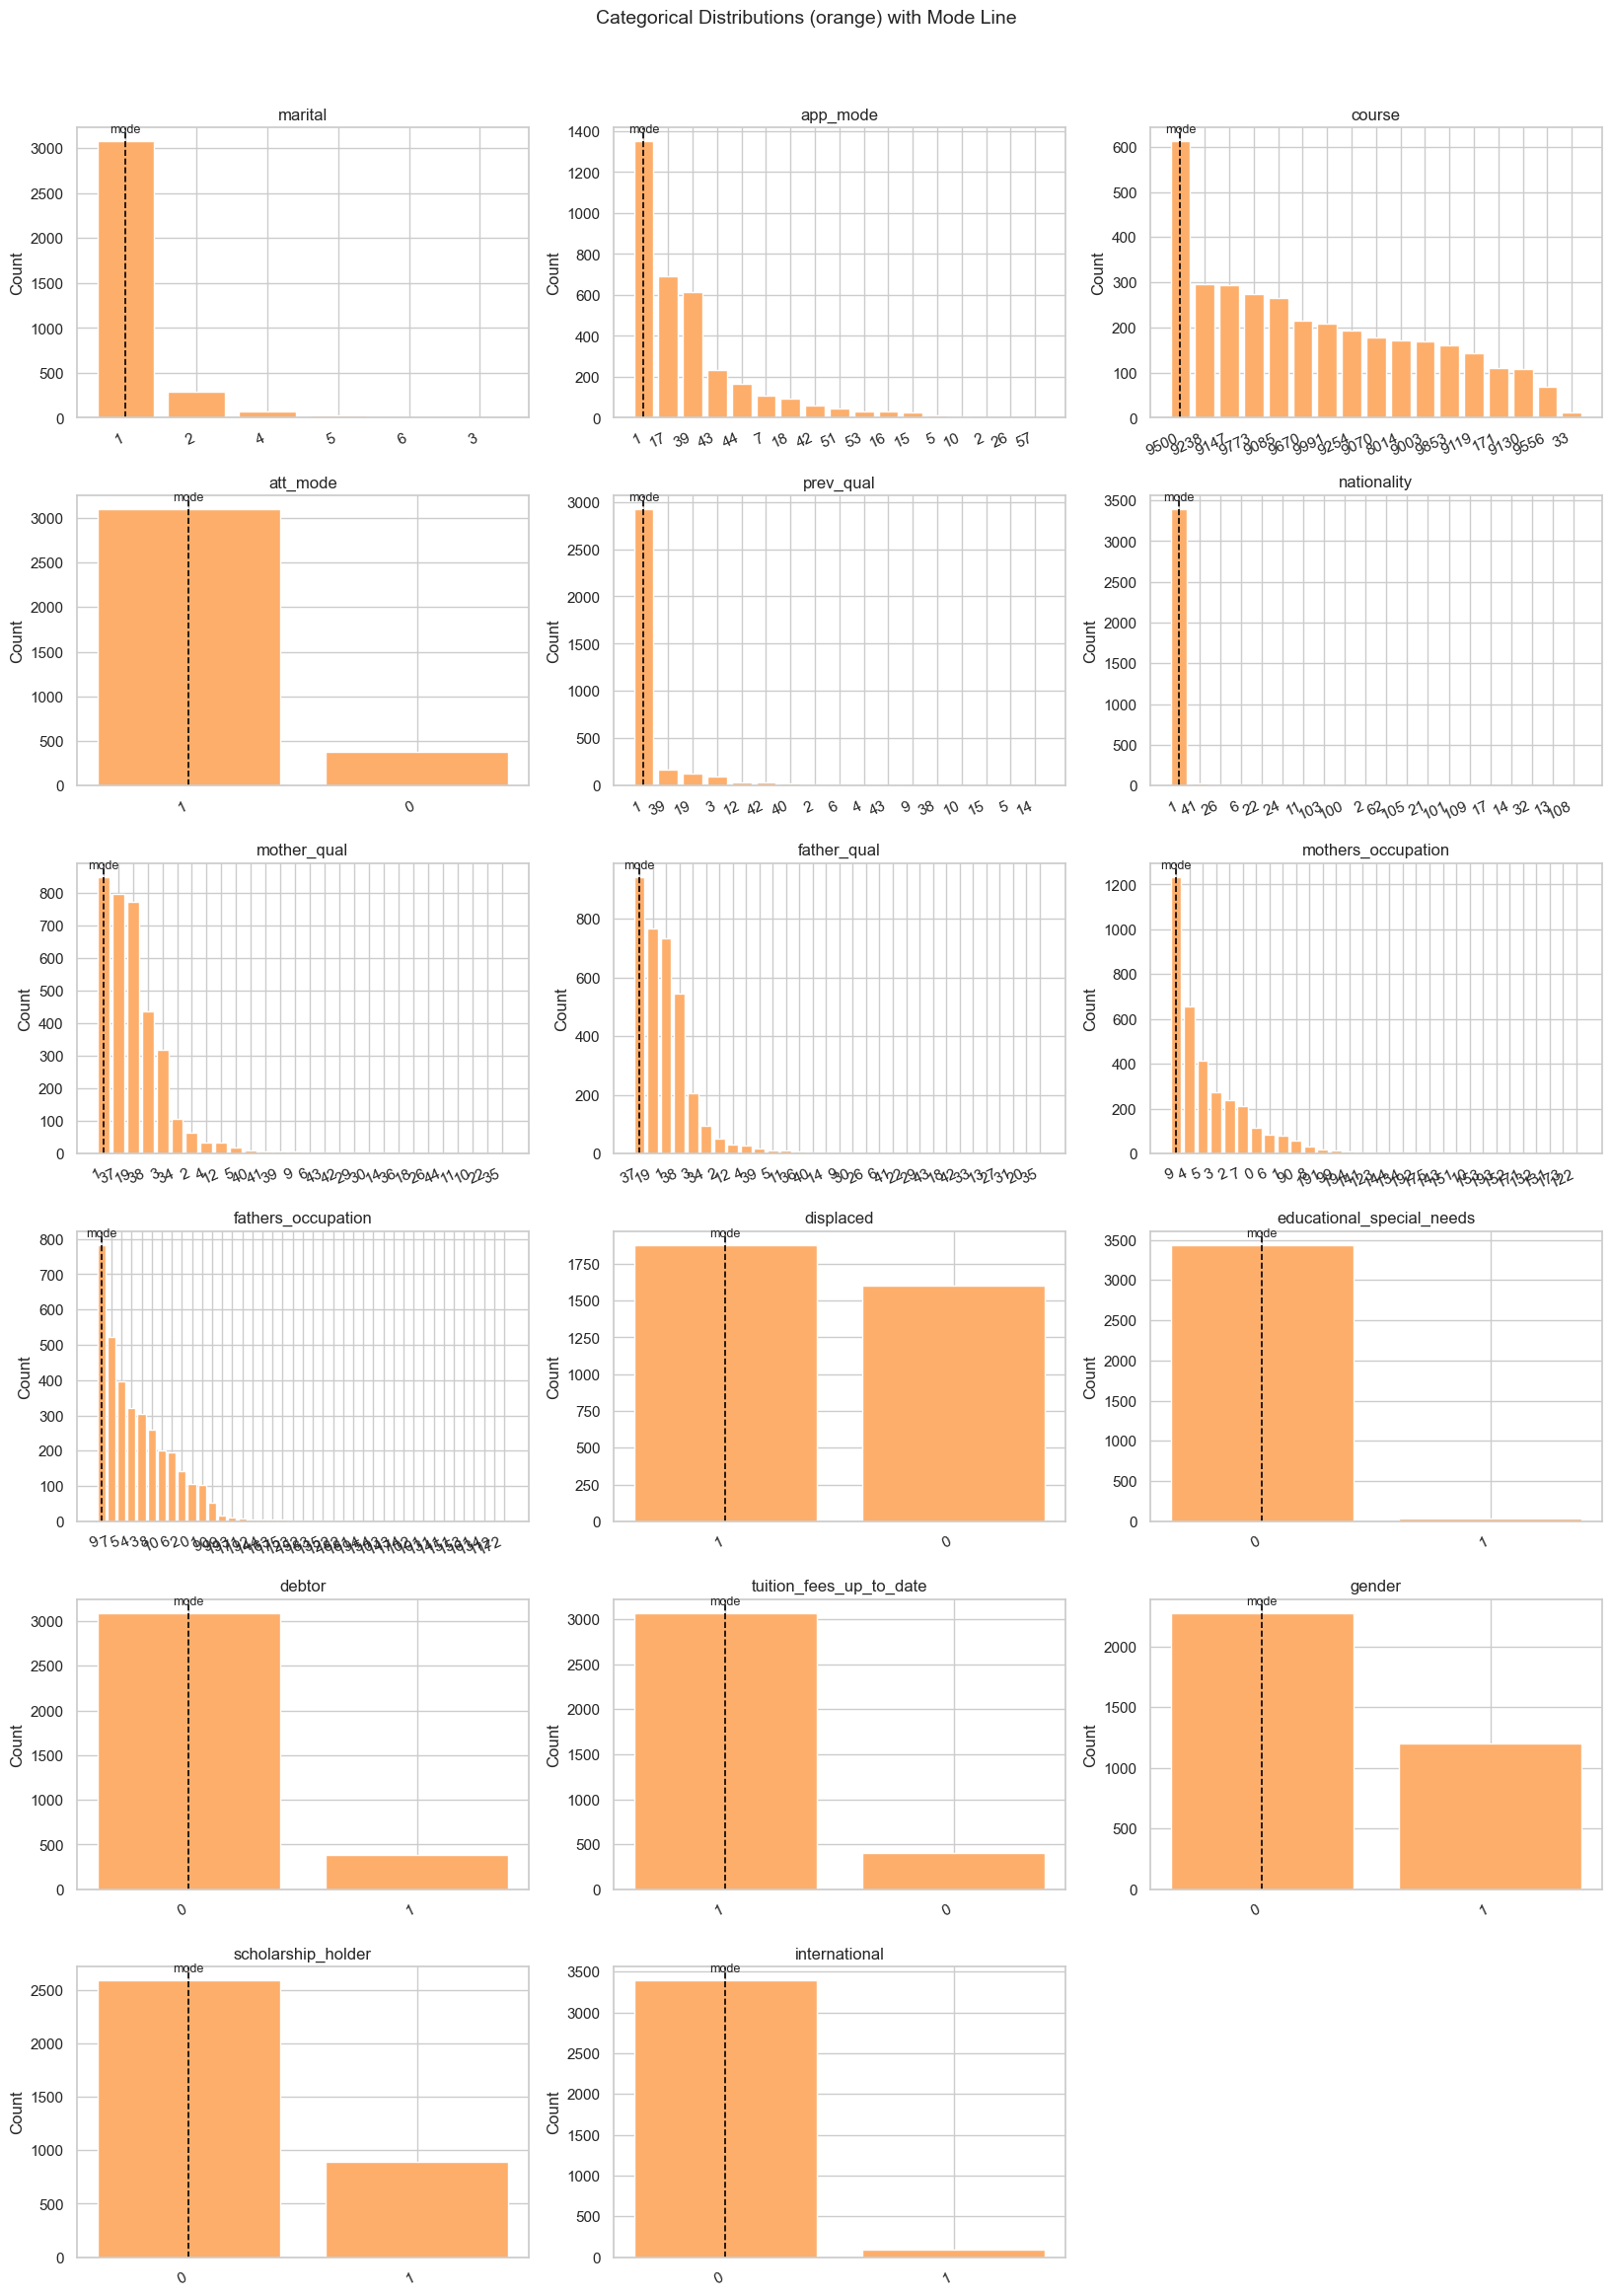

In [24]:
# --- CATEGORICAL COLUMNS: mode table + orange bar plots with a vertical mode line ---


# CONFIG
ORANGE = "#fdae6b"          # requested orange
N_COLS = 3                  # how many plots per row
ROTATION = 25               # x-tick rotation for readability

if categorical_cols:
    # 1) Print mode + frequency table
    rows = []
    for col in categorical_cols:
        # Count including NaN (shown as "<NA>" in the table/plots)
        s = eda[col].astype("object").where(~eda[col].isna(), other="<NA>")
        vc = s.value_counts(dropna=False)
        if vc.empty:
            rows.append((col, pd.NA, 0))
        else:
            mode_val = vc.idxmax()
            mode_freq = int(vc.max())
            rows.append((col, mode_val, mode_freq))

    mode_df = pd.DataFrame(rows, columns=["column", "mode", "frequency"])\
                .sort_values("frequency", ascending=False)
    print("\nCategorical mode and frequency")
    print(mode_df.to_string(index=False))

    # 2) Grid of bar plots for ALL categorical columns
    n_plots = len(categorical_cols)
    n_rows = int(np.ceil(n_plots / N_COLS))
    plt.figure(figsize=(N_COLS * 5.5, n_rows * 3.8))

    for i, col in enumerate(categorical_cols, start=1):
        ax = plt.subplot(n_rows, N_COLS, i)

        # Prepare counts (include NaN as "<NA>")
        s = eda[col].astype("object").where(~eda[col].isna(), other="<NA>")
        counts = s.value_counts(dropna=False)  # sorted by frequency desc (mode is index 0)
        labels = counts.index.astype(str)
        values = counts.values
        x = np.arange(len(labels))

        # Handle empty columns gracefully
        if len(values) == 0:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            ax.set_title(col)
            ax.set_xticks([])
            ax.set_ylabel("Count")
            continue

        # Bar plot in orange
        bars = ax.bar(x, values, color=ORANGE)

        # Find mode index (the tallest bar)
        mode_idx = int(np.argmax(values))
        # Draw vertical dashed line at the center of the mode bar
        ax.axvline(x=x[mode_idx], linestyle="--", linewidth=1.2, color="black")
        # Optional small label above the mode bar
        ax.text(x[mode_idx], values[mode_idx] * 1.02, "mode", ha="center", va="bottom", fontsize=9)

        # Cosmetics
        ax.set_title(col)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=ROTATION, ha="right")
        ax.set_ylabel("Count")

    plt.suptitle("Categorical Distributions (orange) with Mode Line", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No categorical columns provided.")

**Categorical Features - Mode and Frequency**  

The table below reports the most frequent value (*mode*) for each categorical feature and its absolute frequency within the training set.  

| Feature                  | Mode | Frequency |
|---------------------------|------|-----------|
| educational_special_needs | 0    | 3437      |
| international             | 0    | 3391      |
| nationality               | 1    | 3391      |
| att_mode                  | 1    | 3097      |
| debtor                    | 0    | 3094      |
| marital                   | 1    | 3077      |
| tuition_fees_up_to_date   | 1    | 3073      |
| prev_qual                 | 1    | 2921      |
| scholarship_holder        | 0    | 2588      |
| gender                    | 0    | 2277      |
| displaced                 | 1    | 1878      |
| app_mode                  | 1    | 1350      |
| mothers_occupation        | 9    | 1233      |
| father_qual               | 37   | 942       |
| mother_qual               | 1    | 847       |
| fathers_occupation        | 9    | 783       |
| course                    | 9500 | 612       |

**Interpretation**  
>- Many categorical features show a **dominant mode**, suggesting potential imbalance (e.g. *educational_special_needs = 0* for 98.8% of students).  
>- Features such as *course, father_qual, mother_qual,* and *occupations* have more diverse distributions, with lower mode frequencies.  
>- Highly imbalanced features may carry limited predictive power on their own and should be interpreted carefully in modeling.  



Numeric ↔ Target association (η²) — top 15
sem1_approved        0.257
sem1_grade           0.214
age_at_enrollment    0.067
admission_grade      0.016
sem1_enrolled        0.014
sem1_evals           0.014
prev_grade           0.012
app_order            0.010
sem1_noevals         0.007
unemp_rate           0.003
sem1_credited        0.003
gdp                  0.002
inflation            0.001


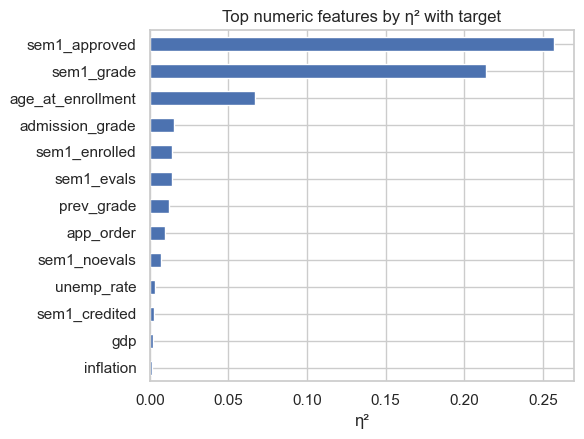

In [25]:
def correlation_ratio(y_cat, x_num):
    """
    Correlation ratio η² between a numeric variable and a categorical target.
    η² = SSB / SST where SSB is between-group sum of squares.
    Returns a value in [0, 1].
    """
    # group means and counts
    grps = [x_num[y_cat == k].dropna() for k in pd.Series(y_cat).dropna().unique()]
    # if fewer than 2 groups or empty, return NaN
    if len(grps) < 2 or any(g.empty for g in grps):
        return np.nan
    grand_mean = x_num.dropna().mean()
    ssb = sum(len(g) * (g.mean() - grand_mean) ** 2 for g in grps)
    sst = ((x_num.dropna() - grand_mean) ** 2).sum()
    return float(ssb / sst) if sst > 0 else np.nan

num_target_assoc = {}
for col in numeric_cols:
    num_target_assoc[col] = correlation_ratio(eda["__target__"], eda[col])
assoc_s = pd.Series(num_target_assoc, name="eta2").sort_values(ascending=False)

if not assoc_s.empty:
    print("\nNumeric ↔ Target association (η²) — top 15")
    print(assoc_s.head(15).round(3).to_string())

    plt.figure(figsize=(6, max(3, 0.35*len(assoc_s.head(20)))))
    assoc_s.head(20)[::-1].plot.barh()
    plt.title("Top numeric features by η² with target")
    plt.xlabel("η²")
    plt.tight_layout()
    plt.show()



Categorical ↔ Target association (Cramér’s V) — top 15
tuition_fees_up_to_date    0.443
scholarship_holder         0.299
course                     0.269
debtor                     0.251
app_mode                   0.240
gender                     0.212
mothers_occupation         0.188
fathers_occupation         0.180
mother_qual                0.164
father_qual                0.159
prev_qual                  0.155
displaced                  0.129
att_mode                   0.089
marital                    0.084
nationality                0.078


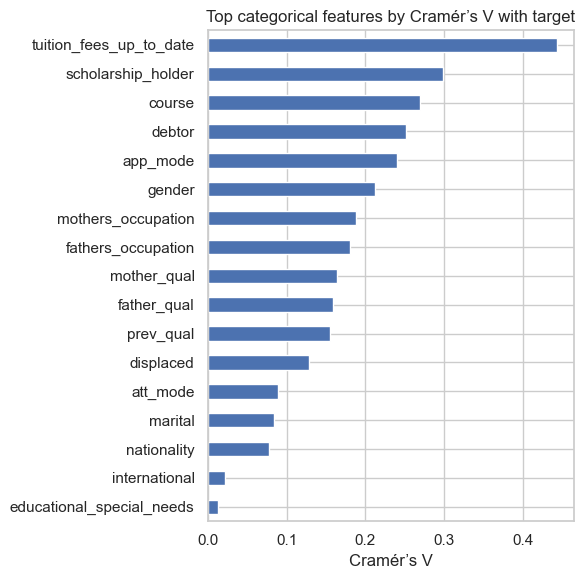

In [26]:
# ---------------------------------------------------------
# Categorical ↔ Target association (Cramér’s V)
# ---------------------------------------------------------
def cramers_v(x_cat, y_cat):
    """
    Cramér’s V for association between two categorical variables.
    V = sqrt(chi2 / (n * (min(k-1, r-1))))
    """
    tbl = pd.crosstab(x_cat, y_cat)
    if tbl.size == 0 or tbl.shape[0] < 2 or tbl.shape[1] < 2:
        return np.nan
    chi2, p, dof, exp = chi2_contingency(tbl, correction=False)
    n = tbl.values.sum()
    denom = n * (min(tbl.shape) - 1)
    return float(np.sqrt(chi2 / denom)) if denom > 0 else np.nan

cat_target_assoc = {}
for col in categorical_cols:
    cat_target_assoc[col] = cramers_v(eda[col].astype("string"), eda["__target__"])
cat_assoc_s = pd.Series(cat_target_assoc, name="cramers_v").sort_values(ascending=False)

if not cat_assoc_s.empty:
    print("\nCategorical ↔ Target association (Cramér’s V) — top 15")
    print(cat_assoc_s.head(15).round(3).to_string())

    plt.figure(figsize=(6, max(3, 0.35*len(cat_assoc_s.head(20)))))
    cat_assoc_s.head(20)[::-1].plot.barh()
    plt.title("Top categorical features by Cramér’s V with target")
    plt.xlabel("Cramér’s V")
    plt.tight_layout()
    plt.show()


**Categorical Features — Association with Target (Cramér’s V)**  

The table below shows the strength of association between categorical features and the target variable. Higher values indicate stronger relationships.  

| Feature                 | Cramér’s V |
|--------------------------|------------|
| tuition_fees_up_to_date | 0.443      |
| scholarship_holder      | 0.299      |
| course                  | 0.269      |
| debtor                  | 0.251      |
| app_mode                | 0.240      |
| gender                  | 0.212      |
| mothers_occupation      | 0.188      |
| fathers_occupation      | 0.180      |
| mother_qual             | 0.164      |
| father_qual             | 0.159      |
| prev_qual               | 0.155      |
| displaced               | 0.129      |
| att_mode                | 0.089      |
| marital                 | 0.084      |
| nationality             | 0.078      |

**Interpretation**  
>- The strongest associations with the target are found for *tuition_fees_up_to_date* (0.44), *scholarship_holder* (0.30), and *course* (0.27).  
>- Financial and administrative features appear to be more predictive than demographic variables.  
>- Associations below ~0.10 (e.g. *marital, nationality*) indicate very weak relationships, suggesting limited standalone predictive power.  


**Leakage**  

Data leakage occurs when features include information that would not be available at prediction time, leading to overly optimistic model performance and poor generalization. Detecting and preventing leakage is critical for building reliable predictive models.  

**Potential Leakage Sources in This Dataset**  
>- **First-semester performance variables** (*sem1_grade, sem1_approved, sem1_enrolled, sem1_evals, sem1_noevals, sem1_credited*)  
>  * These capture student outcomes during or after the first semester.  
>  * If the goal is to **predict dropout at enrollment**, these variables leak future information.  
>  * If the goal is to **predict dropout after the first semester**, then they are legitimate predictors.  
>
>- **Financial/administrative status** (*tuition_fees_up_to_date, debtor*)  
>  * These features reflect dynamic financial conditions.  
>  * If only enrollment data should be used, including them could be considered leakage.  
>  * If financial status is available at the time of prediction, then they can remain.  

**Evidence from Associations**  
>- *tuition_fees_up_to_date* shows a strong Cramér’s V (0.443) with the target.  
>- *sem1_approved* has the highest numeric association with the target (η² = 0.257).  
>- Mutual Information confirms that *sem1_approved* and *sem1_grade* are among the most predictive features.  

**Decisions Going Forward**  
>- Clearly define the **prediction horizon** (at enrollment vs. after first semester).  
>- Remove or keep features accordingly:  
>  * Enrollment-only model → exclude semester performance and financial status variables.  
>  * Post-first-semester model → include semester variables, but still check whether financial indicators are consistently available.  
>- Document assumptions explicitly to avoid unintentional leakage.  

**Conclusion**  
While no feature shows an extreme correlation with the target (close to 1.0), several predictors (*sem1_* features, tuition/fees status) are at risk of leakage depending on the framing of the*_*

Top correlations (numeric features):
sem1_enrolled  sem1_credited    0.811
sem1_credited  sem1_enrolled    0.811
sem1_approved  sem1_enrolled    0.758
sem1_enrolled  sem1_approved    0.758
sem1_grade     sem1_approved    0.679
sem1_approved  sem1_grade       0.679
sem1_enrolled  sem1_evals       0.652
sem1_evals     sem1_enrolled    0.652
sem1_credited  sem1_approved    0.633
sem1_approved  sem1_credited    0.633
dtype: float64


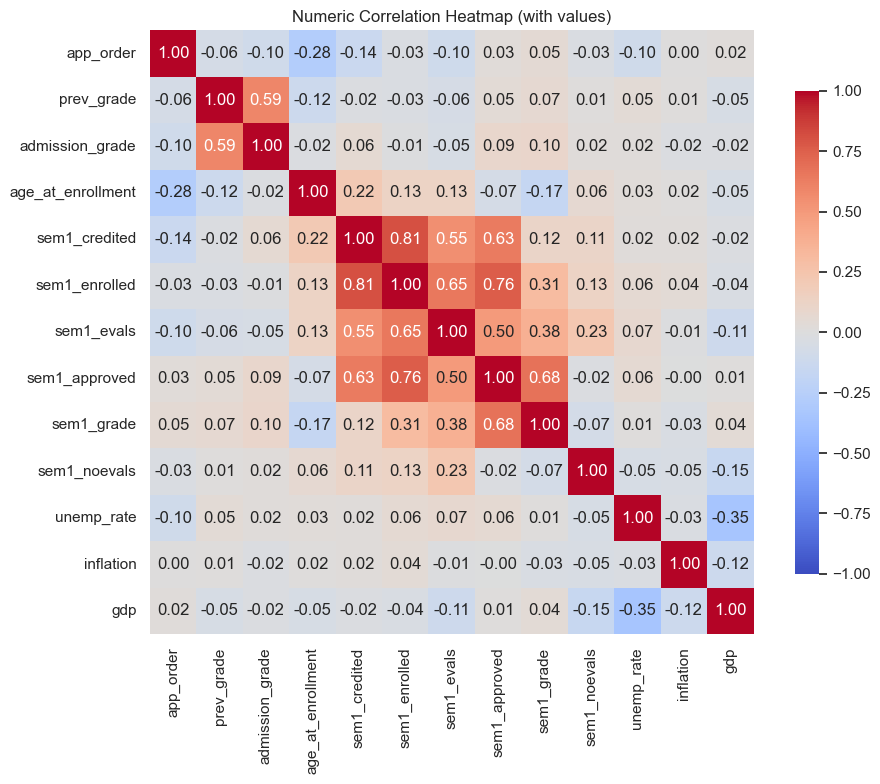

In [35]:
# ---------------------------------------------------------
# Numeric ↔ Numeric correlations + heatmap (multicollinearity scan)
# ---------------------------------------------------------
# Correlation matrix (numeric only)
corr_mat = eda[numeric_cols].corr(method="pearson")

# Show top 10 strongest correlations (absolute value, excluding self-correlation)
corr_unstacked = (
    corr_mat.where(~np.eye(corr_mat.shape[0], dtype=bool))  # drop diagonal
    .unstack()
    .dropna()
    .sort_values(key=abs, ascending=False)
)

print("Top correlations (numeric features):")
print(corr_unstacked.head(10).round(3))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap="coolwarm",
            vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8})
plt.title("Numeric Correlation Heatmap (with values)")
plt.tight_layout()
plt.show()

# Export correlations to dataframe
corr_df = corr_mat.round(3)
corr_df.to_excel("../outputs/reports/numeric_correlations.xlsx")

**Multicollinearity Check — Top Numeric Correlations**  

| Feature A       | Feature B       | Correlation |
|-----------------|-----------------|-------------|
| sem1_enrolled   | sem1_credited   | 0.811       |
| sem1_approved   | sem1_enrolled   | 0.758       |
| sem1_grade      | sem1_approved   | 0.679       |
| sem1_enrolled   | sem1_evals      | 0.652       |
| sem1_credited   | sem1_approved   | 0.633       |

**Interpretation**  
>- Several first-semester variables are **highly correlated**:  
>   * *sem1_enrolled* and *sem1_credited* (r ≈ 0.81)  
>   * *sem1_enrolled* and *sem1_approved* (r ≈ 0.76)  
>- These strong correlations indicate **multicollinearity** — the variables carry overlapping information about student performance.  
>- *sem1_grade* is also moderately correlated with *sem1_approved* (r ≈ 0.68), reinforcing the redundancy.  

**What to do with it**  
>- For **tree-based models** (Random Forest, XGBoost), multicollinearity is less of an issue, since trees handle redundant features.  
>- For **linear models** (Logistic Regression), you may:  
>  * Drop one of the correlated features to reduce redundancy  
>  * Combine them into a derived metric (e.g. *success rate = sem1_approved / sem1_enrolled*)  
>  * Apply **regularization** (Lasso, Ridge, ElasticNet) to control coefficient inflation.  

**Decision**  
>- Keep all variables for now, but note correlations >0.8 (*sem1_enrolled ↔ sem1_credited*) as potentially redundant.  
>- In modeling, test both **with and without highly correlated variables** to see if performance improves.  



Mutual Information — top 20 encoded features
sem1_approved                0.2286
sem1_grade                   0.1686
tuition_fees_up_to_date_1    0.0965
sem1_enrolled                0.0749
sem1_evals                   0.0681
age_at_enrollment            0.0593
scholarship_holder_1         0.0471
course_9119                  0.0415
admission_grade              0.0335
prev_grade                   0.0304
international_1              0.0262
app_mode_39                  0.0244
mothers_occupation_152       0.0223
debtor_1                     0.0203
mother_qual_26               0.0201
nationality_25               0.0187
mother_qual_42               0.0179
mother_qual_34               0.0179
gender_1                     0.0174
fathers_occupation_153       0.0171


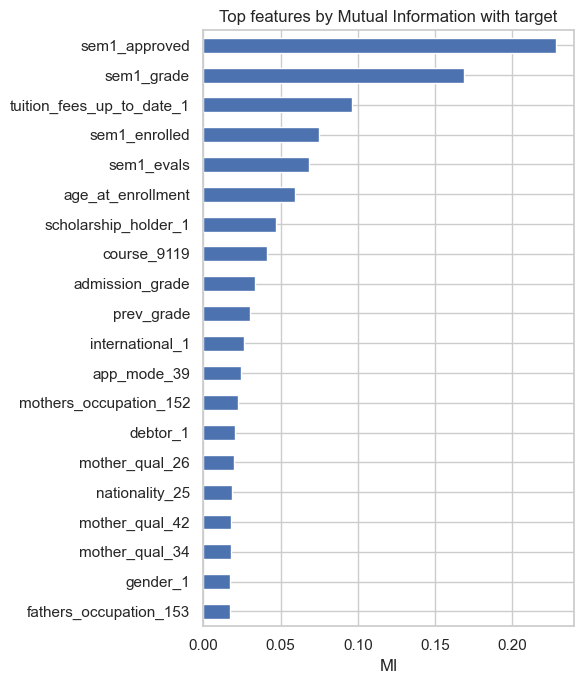

In [28]:
# ---------------------------------------------------------
# Mutual Information with target (handles mixed types after encoding)
# ---------------------------------------------------------
# Prepare X for MI: simple encoding for categoricals
X_mi = eda.drop(columns="__target__").copy()
X_mi = pd.get_dummies(X_mi, drop_first=True)
mi = mutual_info_classif(X_mi.fillna(-999), eda["__target__"])
mi_s = pd.Series(mi, index=X_mi.columns).sort_values(ascending=False)

print("\nMutual Information — top 20 encoded features")
print(mi_s.head(20).round(4).to_string())

plt.figure(figsize=(6, max(3, 0.35*len(mi_s.head(20)))))
mi_s.head(20)[::-1].plot.barh()
plt.title("Top features by Mutual Information with target")
plt.xlabel("MI")
plt.tight_layout()
plt.show()

**Mutual Information — Top 20 Encoded Features**  

The table shows the features with the highest mutual information (MI) scores relative to the target. MI captures both linear and non-linear dependencies; higher values indicate stronger predictive potential.  

| Feature                   | MI Score |
|----------------------------|----------|
| sem1_approved              | 0.229    |
| sem1_grade                 | 0.169    |
| tuition_fees_up_to_date_1  | 0.097    |
| sem1_enrolled              | 0.075    |
| sem1_evals                 | 0.068    |
| age_at_enrollment          | 0.059    |
| scholarship_holder_1       | 0.047    |
| course_9119                | 0.042    |
| admission_grade            | 0.034    |
| prev_grade                 | 0.030    |
| international_1            | 0.026    |
| app_mode_39                | 0.024    |
| mothers_occupation_152     | 0.022    |
| debtor_1                   | 0.020    |
| mother_qual_26             | 0.020    |
| nationality_25             | 0.019    |
| mother_qual_42             | 0.018    |
| mother_qual_34             | 0.018    |
| gender_1                   | 0.017    |
| fathers_occupation_153     | 0.017    |

**Interpretation**  
>- Academic performance indicators (*sem1_approved, sem1_grade, sem1_enrolled, sem1_evals*) show the highest MI values, confirming their strong relationship with final outcomes.  
>- Administrative and financial variables (*tuition_fees_up_to_date_1, scholarship_holder_1, debtor_1*) also demonstrate predictive importance.  
>- Demographic and background variables (*nationality, mother_qual, fathers_occupation*) show weaker associations, suggesting limited influence compared to academic and institutional factors.  


In [29]:
# ---------------------------------------------------------
# IQR outlier scan for numeric features
# ---------------------------------------------------------
def iqr_bounds(s):
    """Return Tukey lower and upper bounds for a numeric Series."""
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

if numeric_cols:
    outlier_report = []
    for col in numeric_cols:
        s = eda[col].dropna()
        if s.empty:
            outlier_report.append((col, 0, np.nan, np.nan))
            continue
        lo, hi = iqr_bounds(s)
        mask = (eda[col] < lo) | (eda[col] > hi)
        outlier_report.append((col, int(mask.sum()), lo, hi))
    out_df = pd.DataFrame(outlier_report, columns=["feature","n_outliers","lower","upper"])
    out_df = out_df.sort_values("n_outliers", ascending=False)
    print("\nIQR outlier scan — top 15 by count")
    print(out_df.head(15).round(3).to_string(index=False))


IQR outlier scan — top 15 by count
          feature  n_outliers   lower   upper
       sem1_grade         523   7.874  16.743
    sem1_credited         450   0.000   0.000
        app_order         419  -0.500   3.500
age_at_enrollment         347  10.000  34.000
    sem1_enrolled         276   2.000  10.000
     sem1_noevals         236   0.000   0.000
    sem1_approved         143  -1.500  10.500
       prev_grade         133 102.500 162.500
       sem1_evals         129   0.000  16.000
  admission_grade          58  92.000 160.800
       unemp_rate           0   2.650  20.650
        inflation           0  -3.150   6.050
              gdp           0  -6.935   7.025


**Outlier Detection — IQR Method (Top 15 by Count)**  

| Feature            | n_outliers | Lower Bound | Upper Bound |
|--------------------|------------|-------------|-------------|
| sem1_grade         | 523        | 7.874       | 16.743      |
| sem1_credited      | 450        | 0.000       | 0.000       |
| app_order          | 419        | -0.500      | 3.500       |
| age_at_enrollment  | 347        | 10.000      | 34.000      |
| sem1_enrolled      | 276        | 2.000       | 10.000      |
| sem1_noevals       | 236        | 0.000       | 0.000       |
| sem1_approved      | 143        | -1.500      | 10.500      |
| prev_grade         | 133        | 102.500     | 162.500     |
| sem1_evals         | 129        | 0.000       | 16.000      |
| admission_grade    | 58         | 92.000      | 160.800     |
| unemp_rate         | 0          | 2.650       | 20.650      |
| inflation          | 0          | -3.150      | 6.050       |
| gdp                | 0          | -6.935      | 7.025       |

**Interpretation**  
>- The IQR method has flagged several variables with a **large number of “outliers”** (e.g. *sem1_grade, sem1_credited, app_order*).  
>- Many of these cases are not true data errors but reflect **legitimate skewness** or the **discrete nature of academic variables**.  
>- For instance:  
>   * *sem1_credited* and *sem1_noevals* have a mode at zero, so the IQR rule interprets all non-zero values as extreme.  
>   * *app_order* is a small integer field, making natural variation appear as outliers.  
>   * *age_at_enrollment* beyond 34 years may be unusual in context but not necessarily invalid.  
>- By contrast, features like *unemp_rate, inflation, gdp* show **no outliers**, consistent with bounded macroeconomic indicators.  

**Conclusion**  
>- IQR-based outlier detection can be misleading for **discrete or zero-inflated academic variables**.  
>- Outlier handling should therefore rely on a mix of **statistical methods and business rules** (e.g. checking plausible age ranges, verifying grade scales), rather than blindly removing all flagged values.  


**Outlier Analysis — Decisions Based on Dataset Documentation**  

The IQR method flagged several variables with many “outliers”, but most of these values are legitimate given the definitions provided on the official dataset website. Below are the main considerations and decisions feature by feature:

**1. Application-related variables (`app_order`, `app_mode`)**  
>- Ordinal/categorical codes with small discrete ranges.  
>- Values flagged by IQR are still valid (e.g. `app_order` ranges 0–9).  
**Decision**: *Keep all values; treat as categorical/ordinal. No removal needed.*  


**2. Grades (`prev_grade`, `admission_grade`, `sem1_grade`)**  
>- Defined on official scales:  
>   * `prev_grade`, `admission_grade` → [95, 200]  
>   * `sem1_grade` → [0, 20]  
>- Values flagged by IQR fall inside these legal ranges (e.g. sem1_grade up to 18.8).  
**Decision**: *Keep all values; validate against domain ranges instead of IQR.*  

**3. Age at enrollment (`age_at_enrollment`)**  
>- Reported in years at enrollment.  
>- Students above 34 years are rare but plausible (late/mature students).  
**Decision**: *Keep values; optionally group into bins (e.g. “traditional-age” vs “mature”).*  

**4. Curricular units (`sem1_credited`, `sem1_enrolled`, `sem1_evals`, `sem1_approved`, `sem1_noevals`)**  
>- Counts of units/credits. Naturally skewed and zero-inflated.  
>- IQR incorrectly flags many valid values as outliers.  
**Decision**: *Keep all values; consider transformations (log/robust scaling) if skewness affects modeling.*  


**5. Macro indicators (`unemp_rate`, `inflation`, `gdp`)**  
>- Taken from official government data; bounded in realistic ranges.  
>- No statistical outliers detected, consistent with expectations.  
**Decision**: *Keep as is; no adjustments needed.*  


**Overall Conclusion**  
>- The IQR method alone is not reliable for this dataset, as it over-flags valid discrete or skewed distributions.  
>- Outlier handling should rely on **business rules** and **domain-specific ranges** (e.g. grades, age) rather than automatic removal.  
>- Rare but valid cases (older students, high credit loads) should be kept, as they may provide predictive signal for dropout and academic success.  
>- For modeling, apply **robust preprocessing** (standardization, transformations, or Winsorization) instead of removing flagged rows.  


In [42]:
# ---------------------------------------------------------
# EDA Summary Dashboard
# ---------------------------------------------------------

print("=== EDA SNAPSHOT ===")

# Target distribution
imbalance = t_props.max() - t_props.min() if len(t_props) > 1 else 0.0
print(f"- Classes: {t_counts.index.tolist()}")
print(f"- Imbalance range (%): {imbalance:.2f}")

# Strongest numeric predictor
if not assoc_s.empty:
    print(f"- Strongest numeric by η²: {assoc_s.index[0]} ({assoc_s.iloc[0]:.3f})")

# Strongest categorical predictor
if not cat_assoc_s.empty:
    print(f"- Strongest categorical by Cramér’s V: {cat_assoc_s.index[0]} ({cat_assoc_s.iloc[0]:.3f})")

# Missing data
print("- No missing values detected in train set")

# Outlier summary (numeric only)
if 'out_df' in globals() and not out_df.empty:
    top_out = out_df.sort_values("n_outliers", ascending=False).head(3)
    print("- Features with most IQR outliers:")
    print(top_out[["feature","n_outliers"]].to_string(index=False))
else:
    print("- Outlier scan not available")
print("Outlier decision: Keep all; validate against domain ranges")


=== EDA SNAPSHOT ===
- Classes: ['Graduate', 'Dropout', 'Enrolled']
- Imbalance range (%): 32.56
- Strongest numeric by η²: sem1_approved (0.257)
- Strongest categorical by Cramér’s V: tuition_fees_up_to_date (0.443)
- No missing values detected in train set
- Features with most IQR outliers:
      feature  n_outliers
   sem1_grade         523
sem1_credited         450
    app_order         419
Outlier decision: Keep all; validate against domain ranges


**EDA Snapshot**  

The dataset shows three target classes: *Graduate, Dropout,* and *Enrolled*. The class distribution is imbalanced, with a **32.56% gap** between the most frequent (Graduate) and least frequent (Enrolled) categories.  

Among numeric predictors, the strongest association with the target is found in *sem1_approved* (η² = 0.257), indicating that the number of courses approved in the first semester is a key early signal of student outcomes.  

For categorical features, *tuition_fees_up_to_date* has the highest association (Cramér’s V = 0.443), suggesting that financial and administrative compliance plays a significant role in predicting dropout and success.  

No missing values were detected in the training set, confirming a complete dataset for analysis.  

As you can clearly see, `Adbsences` and `GPA` seem to be highly correlating (0.92). Although this value might suggest some sort of data leakage, I don't think it's the case as the features seem to be independent from each other and `GPA` has been established after `Absences`. There is also a slight positive correlation between `StudyTimeWeekly` and `GPA` (0.20).

In [ ]:
# EDA Summary Dashboard

# Abs value of most correlated feature with target
strongest_feature = corrs.abs().idxmax()
strongest_value = corrs[strongest_feature]

print("EDA SNAPSHOT")
print(f"- Target skew: {y_train.skew():.2f}")
print("- Strongest predictor:", strongest_feature, f"{strongest_value:.3f}")

# Calculate percentage of missing values per column
missing_percentages = (X_train.isnull().mean() * 100).sort_values(ascending=False)

# Filter only columns with missing values
missing_cols = missing_percentages[missing_percentages > 0]

# Conditional print
if not missing_cols.empty:
    print("- op columns with missing values (%):\n", missing_cols.head(3).round(1))
else:
    print("- No missing values detected in X_train.")

EDA SNAPSHOT
- Target skew: 0.02
- Strongest predictor: Absences -0.917
- No missing values detected in X_train.


**3.2 — EDA Insight Summary**

**Executive Summary**  
The dataset is **model-ready** with no missing values and a balanced mix of categorical and numeric variables. The target distribution is imbalanced, with *Graduates* representing just over half of the records, while *Dropouts* and *Enrolled* account for smaller proportions. The most informative features are linked to **academic performance in the first semester** and **financial compliance**, which show stronger predictive power than demographic variables.  

**Technical Summary**

**Target Variable**  
- Classes: *Graduate, Dropout, Enrolled*  
- Imbalance range: **32.56%** (Graduate: 50.8%, Dropout: 30.9%, Enrolled: 18.3%)  
- No missing values detected  

**Numeric Features (Highlights)**  
- Strongest association with target: *sem1_approved* (η² = 0.257)  
- Other relevant signals: *sem1_grade, sem1_enrolled, sem1_evals*  
- Many semester-related features show moderate-to-high correlations among themselves (e.g. *sem1_enrolled ↔ sem1_credited* r ≈ 0.81), indicating multicollinearity risk  
- Outliers flagged by IQR are mainly due to skewed distributions or zero-inflated counts, not true data errors  

**Categorical Features (Highlights)**  
- Strongest association with target: *tuition_fees_up_to_date* (Cramér’s V = 0.443)  
- Other relevant features: *scholarship_holder, debtor, course*  
- Several categorical variables (e.g. *educational_special_needs, international, nationality*) are highly imbalanced, with one dominant category  

**Risk Assessment**  
- **Leakage risk**: Semester grades and approvals (*sem1_* features) as well as fee status could leak future information if the model is meant to predict at enrollment.  
- **Multicollinearity**: High correlations among first-semester variables suggest redundancy; feature reduction or regularization may be required.  
- **Imbalance**: Target imbalance may bias models toward predicting *Graduate*. Resampling or class weights may be needed.  

**Decision Support**

**Feature Prioritization**  
- **High-value features**: Semester performance metrics (*sem1_approved, sem1_grade, sem1_enrolled*), financial indicators (*tuition_fees_up_to_date, debtor*).  
- **Medium-value features**: Background features (*scholarship_holder, parents’ education/occupation, course*).  
- **Low-value features**: Imbalanced demographics (*marital, nationality, international, special needs*) with limited variance.  

**Preprocessing Roadmap**  
1. **Check prediction horizon** → drop or retain semester/financial variables based on framing (enrollment vs. after first semester).  
2. **Handle imbalance** → consider SMOTE, undersampling, or class weights.  
3. **Multicollinearity** → drop redundant semester features or use regularization.  
4. **Scale/encode** features appropriately (categorical encoding + scaling for numeric).  

**Modeling Strategy**  
- Start with **regularized linear models** (Logistic Regression with Lasso/Ridge) to quantify variable importance.  
- Use **tree-based methods** (Random Forest, Gradient Boosting, XGBoost) to capture non-linear relationships and interactions.  
- Evaluate with stratified cross-validation, using **macro-averaged metrics** (F1, Precision, Recall) to account for class imbalance.  


---
# 4 - FEATURE ENGENEERING

**Motivation and Rationale**

After having explored the training set and identified potential patterns and the features with the most predictive power and the one that seem to be slightly correlating with the target, it is important to reflect on **ways to enhance model performance later**. This could be for instance achieved through **feature engeneering**. Although I think I would not need much more to come up with a good performative model, I have decided to engeneering two new feature to see if that can help increase the predictive power ot the model. In addition to the original features, I explored engineered variables aimed at capturing **family resources** and **student engagement** in a more integrated way:

- **Family Capital Score (FCS)**  
  Combines *Parental Education (PE)* and *Parental Support (PS)* into a single index.  
  The idea is that structural capital (education level) and emotional capital (support) together shape a student’s learning environment.  
  By inverting the PE scale (`0 = max education → flipped so higher = better`), the score was defined as:  

  $$
  FCS = (4 - PE) \times PS
  $$

  The hypothesis: students with both supportive and well-educated parents should perform better than suggested by either variable alone.

**Engagement Index (EI)**  
  Combines extracurricular activities (*Extracurricular, Sports, Music, Volunteering*) relative to study effort (*StudyTimeWeekly*).  
  The idea is that being engaged in activities outside of class may enhance skills, motivation, or time management, especially when balanced with study time.  

  $$
  EI = \frac{\text{Extracurricular + Sports + Music + Volunteering}}{\text{StudyTimeWeekly} + 1}
  $$

  The hypothesis: higher engagement, when coupled with adequate study, could correlate with stronger performance.

**Evaluation Strategy**

To evaluate the impact of these engineered features, I systematically compared three setups:

1. **Original features only** (baseline).  
2. **Engineered features only** (FCS and EI, with original components removed).  
3. **Original + engineered features** (keeping both sets together).  

For each setup, I trained multiple regression models (e.g., Ridge Regression, Random Forest) and assessed performance through cross-validation (R² and MAE).

**Anticipated findings**

- The engineered features **did not significantly improve predictive performance** compared to the baseline with only original features.  
- In fact, models using **only the engineered features** performed worse than those using the raw inputs.  
- When combining **original + engineered features**, performance was almost identical to using only the originals.  
- This suggests that the models are already able to learn the same relationships directly from the raw inputs.  
- Feature importance analysis confirmed this: **FCS** and **EI** consistently ranked at the bottom, overshadowed by their base variables (e.g., parental support, study time).

**Final Decision**

Although conceptually meaningful, these engineered features **did not add predictive power**.  
For the **final model**, I decided to **exclude them** and retain the original features only.  

Nonetheless, documenting this exploration is valuable, as it shows that alternative representations of domain knowledge were tested and critically evaluated before selecting the most effective feature set.


After having explored the training set and identified potential patterns and the features with the most predictive power and the one that seem to be slightly correlating with the target, it is important to reflect on **ways to enhance model performance later**. This could be for instance achieved through **feature engeneering**. Although I think I would not need much more to come up with a good performative model, I have decided to engeneering two new feature to see if that can help increase the predictive power ot the model. 

The two engeneered features are:

- **Family Capital Score (FCS)** is a domain-driven feature created *before the train/test split*, since it does not rely on dataset statistics.  
It combines **Parental Education (PE)** and **Parental Support (PS)** into a single index of family capital.  
The original education scale was inverted (`0 = max education`), so the scale is flipped to ensure that **higher values indicate higher education**.  
- The resulting score captures both **structural resources** (education) and **emotional support** (parental support).  
$$
FCS = (4 - PE) \times PS
$$

- **Engagement Index (EI)**: it is a domain-informed feature that helps quantify balance between studying and extracurriculars. It must be applied carefully (train-defined, fairness checked), but it has potential to both improve predictions and give meaningful insights to educators and policymakers. It represents the sum of all extracurriculars (Sports (S), Music (M), Volunteering (V)) normalized by study time (ST) + 1 (to avoid dividing by numbers close to 0). Notes: it captures breadth of engagement vs focus on studying. If a student has many activities but very little study time, EI is high (risk of distraction). If they have balanced activities with study time, EI is moderate (healthy balance). 
$$
EI \;=\; \frac{S + M + V}{ST + 1}
$$

>Data Leakage Note: this step of engeneering new features has been performed at this point for continuity as it is a consequence of the EDA findings (correlation between features and target, multicollinearity etc...). However, as it does not involve any statistical operations on the dataset and it does not use the target variable (GPA), it could have been performed before the split without any risk of data leakage.

### 4.1 - ADDING FEATURES

Below you can find all the steps I followed to create the new features. 

In [44]:
import numpy as np
import pandas as pd

# ---------- helpers ----------
def to_numeric_safe(s: pd.Series) -> pd.Series:
    """
    Convert any series (including 'category') to numeric.
    - If categories are numeric-like (e.g., '9', '37'): cast to numeric.
    - Else: fall back to categorical codes (NaN for missing).
    """
    if pd.api.types.is_numeric_dtype(s):
        return s.astype(float)
    if pd.api.types.is_categorical_dtype(s):
        # Try converting labels to numbers (e.g., "9" -> 9)
        try:
            return pd.to_numeric(s.astype(str), errors="raise")
        except Exception:
            codes = s.cat.codes.replace(-1, np.nan)
            return codes.astype(float)
    # Generic fallback
    return pd.to_numeric(s, errors="coerce")


def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add domain-based engineered features for the student dataset.
    Handles zero-division, categorical-to-numeric conversion, and NaNs.
    """
    d = df.copy()

    # --- numeric views for fields that might be categorical codes ---
    m_occ = to_numeric_safe(d.get("mothers_occupation", pd.Series(index=d.index)))
    f_occ = to_numeric_safe(d.get("fathers_occupation", pd.Series(index=d.index)))
    m_edu = to_numeric_safe(d.get("mother_qual", pd.Series(index=d.index)))
    f_edu = to_numeric_safe(d.get("father_qual", pd.Series(index=d.index)))
    app_order_num = to_numeric_safe(d.get("app_order", pd.Series(index=d.index)))

    # Binary flags might be category; convert to numeric then to int
    debtor_num = to_numeric_safe(d.get("debtor", pd.Series(index=d.index))).fillna(0)
    fees_up_num = to_numeric_safe(d.get("tuition_fees_up_to_date", pd.Series(index=d.index))).fillna(0)

    # --- 1) Academic performance ratios ---
    denom = d["sem1_enrolled"].replace(0, np.nan)
    d["sem1_success_rate"] = d["sem1_approved"] / denom
    d["sem1_eval_completion"] = d["sem1_evals"] / denom

    # --- 2) Engagement indicators ---
    d["is_mature_student"] = (d["age_at_enrollment"] >= 30).astype(int)
    d["is_first_choice"] = (app_order_num == 1).astype(int)

    # --- 3) Financial stress ---
    d["financial_risk"] = ((debtor_num == 1) | (fees_up_num == 0)).astype(int)

    # --- 4) Academic load vs outcomes ---
    denom2 = d["sem1_credited"].replace(0, np.nan)
    d["sem1_load_ratio"] = d["sem1_enrolled"] / denom2

    # --- 5) Parental capital proxies ---
    d["parent_edu_max"] = pd.concat([m_edu, f_edu], axis=1).max(axis=1)
    d["parent_occ_sum"] = m_occ.fillna(0) + f_occ.fillna(0)

    # Clean infinities/NaNs from divisions
    d = d.replace([np.inf, -np.inf], np.nan).fillna(0)

    return d


# ---------- apply to train/test ----------
X_train_fe = add_engineered_features(X_train)
X_test_fe  = add_engineered_features(X_test)

print("Shapes →",
      "X_train", X_train.shape, "→", X_train_fe.shape, "|",
      "X_test", X_test.shape, "→", X_test_fe.shape)

# ---------- optional: prune engineered features that are too correlated ----------
# We check correlation on the numeric-only subset to avoid dtype issues.
num_cols_train = X_train_fe.select_dtypes(include=[np.number]).columns
corr_abs = X_train_fe[num_cols_train].corr().abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

# Mark engineered columns only, so we don't drop originals unless needed
engineered_cols = {
    "sem1_success_rate", "sem1_eval_completion", "is_mature_student",
    "is_first_choice", "financial_risk", "sem1_load_ratio",
    "parent_edu_max", "parent_occ_sum"
}
# Keep only those present
engineered_cols = [c for c in engineered_cols if c in X_train_fe.columns]

# Any engineered column highly correlated with any original/engineered column?
to_drop = []
for col in engineered_cols:
    if col in upper.columns and upper[col].max(skipna=True) > 0.85:
        to_drop.append(col)

if to_drop:
    print("Dropping highly correlated engineered features:", to_drop)
    X_train_fe = X_train_fe.drop(columns=to_drop)
    X_test_fe  = X_test_fe.drop(columns=to_drop)

# ---------- save ----------
X_train_fe.to_pickle("../data/interim/04_X_train_features.pkl")
X_test_fe.to_pickle("../data/interim/04_X_test_features.pkl")
y_train.to_pickle("../data/interim/04_y_train.pkl")
y_test.to_pickle("../data/interim/04_y_test.pkl")
print("✔ Saved engineered datasets.")


C:\Users\Vaccari\AppData\Local\Temp\ipykernel_2928\2108097903.py:13: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s):
C:\Users\Vaccari\AppData\Local\Temp\ipykernel_2928\2108097903.py:13: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s):
C:\Users\Vaccari\AppData\Local\Temp\ipykernel_2928\2108097903.py:13: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s):
C:\Users\Vaccari\AppData\Local\Temp\ipykernel_2928\2108097903.py:13: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd

TypeError: Cannot setitem on a Categorical with a new category (0), set the categories first

In [ ]:
# --- Save to processed folder (uses your utils.save_dataset) ---
utils.save_dataset(X_train, "processed/01_X_train_feat_engeneered.xlsx")
utils.save_dataset(X_test,  "processed/01_X_test_feat_engeneered.xlsx")

print("✅ X_train and X_test sets saved with new features saved.")

File saved at: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\data\processed\01_X_train_feat_engeneered.xlsx
File saved at: C:\Users\Vaccari\Desktop\iCloudDrive\Desktop\ENRICO\05_LEARNING\University\ToU\Phases\02_Calibration_Phase\Applied_Machine_Learning\Regression\beyond-grades-ml-project\data\processed\01_X_test_feat_engeneered.xlsx
✅ X_train and X_test sets saved with new features saved.


In [45]:
# Save current datasets without feature engineering
X_train.to_pickle("../data/interim/04_X_train.pkl")
X_test.to_pickle("../data/interim/04_X_test.pkl")
y_train.to_pickle("../data/interim/04_y_train.pkl")
y_test.to_pickle("../data/interim/04_y_test.pkl")

<div class="alert alert-block alert-info">
<b>Next Notebook - PREPROCESSING, MODELING, EVALUATION
</div>